# 5. Faster R-CNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/object-detection/Ch5-Faster-R-CNN.ipynb)

In [5]:
import os
os.chdir('./drive/MyDrive/FR/')

In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 5.1 데이터 불러오기


In [6]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.
Downloading...
From: https://drive.google.com/uc?id=1pJtohTc9NGNRzHj5IsySR39JIRPfkgD3
To: /content/drive/MyDrive/FR/Face Mask Detection.zip
100% 417M/417M [00:06<00:00, 61.4MB/s]
Face Mask Detection.zip download complete!


## 5.2 데이터 분리


3.3절과 같이 데이터셋을 분리해보도록 하겠습니다. 아래 코드를 통해 임의로 170장을 추출하고 test폴더에 옮기는 작업을 수행합니다.

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


또한 모델링에 필요한 패키지를 불러오겠습니다. `torchvision`은 이미지 처리를 하기 위해 사용되며 데이터셋에 관한 패키지와 모델에 관한 패키지가 내장되어 있습니다.

In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

## 5.3 데이터셋 클래스 정의

In [ ]:
import pandas as pd
temp = pd.read_xml('./annotations/maksssksksss0.xml')


In [ ]:
temp

,folder,filename,width,height,depth,segmented,name,pose,truncated,occluded,difficult,bndbox
0,images,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
1,None,maksssksksss0.png,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
2,None,None,512.0,366.0,3.0,NaN,None,None,NaN,NaN,NaN,NaN
3,None,None,NaN,NaN,NaN,0.0,None,None,NaN,NaN,NaN,NaN
4,None,None,NaN,NaN,NaN,NaN,without_mask,Unspecified,0.0,0.0,0.0,NaN
5,None,None,NaN,NaN,NaN,NaN,with_mask,Unspecified,0.0,0.0,0.0,NaN
6,None,None,NaN,NaN,NaN,NaN,without_mask,Unspecified,0.0,0.0,0.0,NaN


In [ ]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1


## label 만드는 함수, with_mask 유무와 None, 총 3개의 label로 분류함 | with mask는 2 without mask는 3 defal=ult는 1이고 transfer learning되는애가 0인듯
def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"].cpu())):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

## 5.4 모델 불러오기

`torchvision.models.detection`에서는 Faster R-CNN API(`torchvision.models.detection.fasterrcnn_resnet50_fpn`)를 제공하고 있어 쉽게 구현이 가능합니다. 이는 COCO 데이터셋을 ResNet50으로 pre-trained한 모델을 제공하고 있으며, `pretrained=True/False`로 설정할 수 있습니다.

이후 모델을 불러올 때는 `num_classes`에 원하는 클래스 개수를 설정하고 모델을 사용하면 됩니다. Faster R-CNN 사용 시 주의할 점은 background 클래스를 포함한 개수를 `num_classes`에 명시해주어야 합니다. 즉, 실제 데이터셋의 클래스 개수에 1개를 늘려 background 클래스를 추가해주어야 합니다.

In [ ]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 5.5 전이 학습



Face Mask Detection에 전이 학습을 실시해 보겠습니다. Face Mask Detection 데이터셋은 3개의 클래스로 이루어져 있지만 background 클래스를 포함하여 `num_classes`를 4로 설정한 후 모델을 불러옵니다.

GPU를 사용할 수 있는 환경이라면 device로 지정하여 불러온 모델을 GPU에 보내줍니다.

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.is_available()
num_epochs = 30
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    best_ep = 0; best_loss =100000
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

    if epoch_loss < best_loss :
      epoch_loss = best_loss
      best_ep = epoch+1

----------------------train start--------------------------
epoch : 1, Loss : 76.88104248046875, time : 252.55948185920715
epoch : 2, Loss : 49.76942825317383, time : 252.0231523513794
epoch : 3, Loss : 41.355655670166016, time : 252.29558682441711
epoch : 4, Loss : 36.13175582885742, time : 252.1891574859619
epoch : 5, Loss : 33.826541900634766, time : 252.20657563209534
epoch : 6, Loss : 34.095218658447266, time : 252.24318933486938
epoch : 7, Loss : 31.040231704711914, time : 252.34957814216614
epoch : 8, Loss : 28.581100463867188, time : 252.16279697418213
epoch : 9, Loss : 25.78823471069336, time : 252.62944197654724
epoch : 10, Loss : 25.603334426879883, time : 252.42444515228271
epoch : 11, Loss : 25.25847625732422, time : 252.19223189353943
epoch : 12, Loss : 24.571414947509766, time : 251.97076773643494
epoch : 13, Loss : 23.233793258666992, time : 252.2844512462616
epoch : 14, Loss : 22.171918869018555, time : 252.33495593070984
epoch : 15, Loss : 22.04361343383789, time : 25

학습시킨 가중치를 저장하고 싶다면, `torch.save`를 이용하여 저장해두고 나중에 언제든지 불러와 사용할 수 있습니다.

In [ ]:
torch.save(model.state_dict(),f'model_{best_ep}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{best_ep}.pt'))
model.eval()

## 5.6 예측



모델 학습이 끝났으면 잘 학습되었는지 예측 결과를 확인해보겠습니다. 예측결과에는 바운딩 박스의 좌표(boxes)와 클래스(labels), 점수(scores)가 포함됩니다. 점수(scores)에는 해당 클래스의 신뢰도 값이 저장되는데 threshold로 0.5 이상인 것만 추출하도록 함수`make_prediction`를 정의하겠습니다. 그리고 test_data_loader의 첫번째 배치에 대해서만 결과를 출력해보았습니다.

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[215.2087,  59.4504, 250.3136,  97.3991]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9874], device='cuda:0')}, {'boxes': tensor([[219.0123,  99.7483, 257.3086, 140.0911],
        [130.0213, 109.6879, 179.7161, 154.1571],
        [ 41.6297, 109.8195,  67.2455, 140.5293],
        [165.2649,  89.9712, 179.6101, 109.6585],
        [ 83.3216,  83.9007,  94.4419,  98.0366],
        [304.2208, 131.5405, 330.6319, 159.4969],
        [ 29.8916,  89.1010,  45.2737, 104.2733],
        [  3.5001, 103.8937,  21.4035, 127.9139]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.9958, 0.9939, 0.9896, 0.9878, 0.9870, 0.9757, 0.9610],
       device='cuda:0')}, {'boxes': tensor([[336.2697,  25.9319, 363.3057,  52.2752],
        [ 25.0661,  19.8892,  50.1554,  48.5969],
        [179.3206,  75.9750, 215.0263, 112.1818],
        [ 56.4832, 204.6519, 112.9730, 262.3690],
        [122.0548, 156.39

예측된 결과를 이용하여 이미지 위에 바운딩 박스를 그려보도록 하겠습니다. 위에서 정의한 `plot_image_from_output` 함수로 그림을 출력합니다. Target이 실제 바운딩 박스 위치이며 Prediction이 모델의 예측 결과입니다. 모델이 실제 바운딩 박스의 위치를 잘 찾은 것을 확인할 수 있습니다. 


In [ ]:
annotations[0]

{'boxes': tensor([[212.,  57., 251., 106.]]), 'labels': tensor([2])}

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


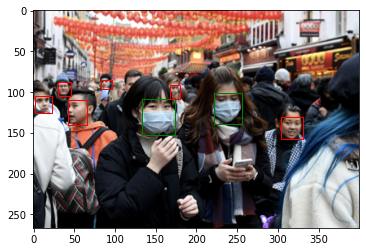

Prediction :  tensor([2, 2, 2, 2, 2, 2], device='cuda:0')


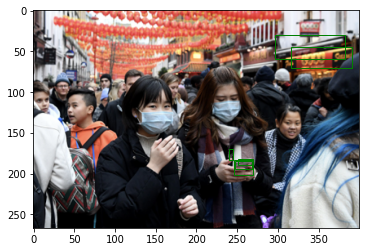

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

Target :  tensor([2])


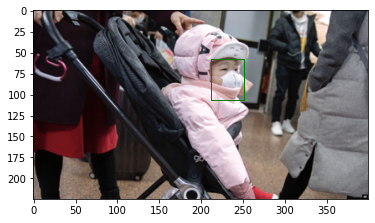

Prediction :  tensor([2], device='cuda:0')


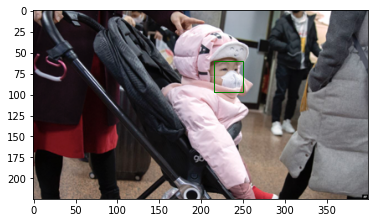

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


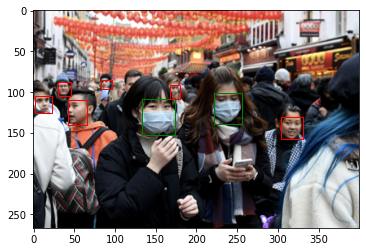

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0')


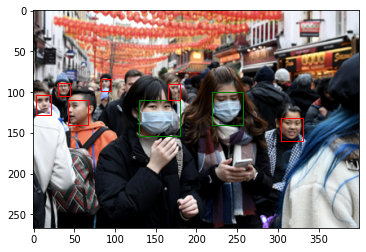

Target :  tensor([1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 2])


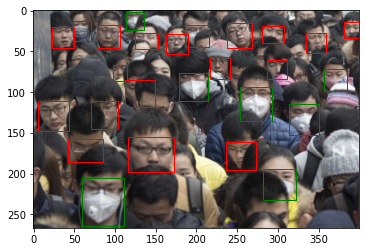

Prediction :  tensor([1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 2, 2, 2], device='cuda:0')


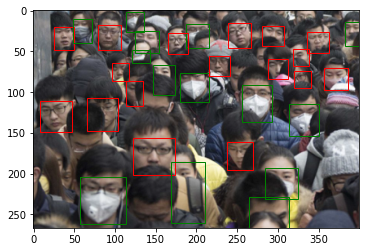

Target :  tensor([3])


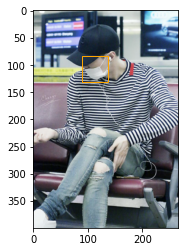

Prediction :  tensor([2], device='cuda:0')


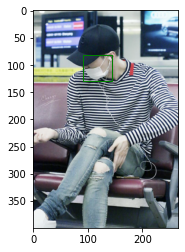

IndexError: ignored

In [ ]:
idxs = np.arange(5)
for _idx in idxs:
  print("Target : ", annotations[_idx]['labels'])
  plot_image_from_output(imgs[_idx], annotations[_idx])
  print("Prediction : ", pred[_idx]['labels'])
  plot_image_from_output(imgs[_idx], pred[_idx])

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


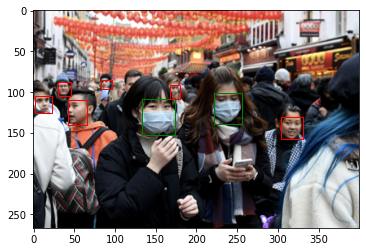

Prediction :  tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0')


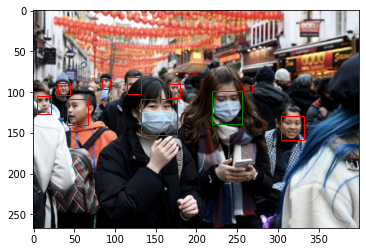

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

이번엔 전체 시험 데이터에 대해서 예측 결과를 평가해보도록 하겠습니다. 먼저 모든 시험 데이터에 대한 예측 결과와 실제 label을 각각 `preds_adj_all`, `annot_all`에 담아줍니다.

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 85/85 [00:27<00:00,  3.12it/s]


그리고 Tutorial-Book-Utils 폴더 내에 있는 utils_ObjectDetection.py 파일을 통해서 mAP 값을 산출합니다. `get_batch_statistics` 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 바운딩 박스간의 통곗값을 계산후 `ap_per_class` 함수를 통해 각 클래스에 대한 AP값을 계산해줍니다.

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7537200840349785
AP : tensor([0.8440, 0.9147, 0.5024], dtype=torch.float64)


AP값은 background 클래스를 제외한 실제 3개의 클래스에 대해서만 보여줍니다.  10번만 학습했음에도 불구하고 4장의 RetinaNet 결과보다 향상된 것을 확인할 수 있습니다. 특히나 1번 클래스인 마스크 착용 객체에 대해서는 0.9189 AP에 해당하는 정확도까지 보이고 2번 클래스인 마스크를 제대로 착용하고 있지 않는 객체에서도 0.3664 AP를 보이고 있습니다.
RetinaNet이 FPN과 Focal loss로 one-stage method임에도 높은 성능을 보인다고 일반적으로 알려져 있습니다. 물론 하이퍼파라미터 튜닝을 통해 RetinaNet의 성능을 최적화 해도 되겠지만, 현재 실험 결과로 미뤄봤을 때 이 데이터셋에는 Faster-RCNN이 더 좋은 성능을 보이고 있습니다. 